<a href="https://colab.research.google.com/github/KimJunGu9/6.DL/blob/main/15_%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98%EB%A1%9C_%EB%AA%A8%EB%8D%B8_%EA%B5%AC%ED%98%84%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# 손글씨 데이터셋을 내려받음
training_data = datasets.MNIST(  # 데이터셋 안에 있는 MNIST
    root="data",
    train=True,
    download=True,
    transform=ToTensor()  # 데이터셋을 텐서로 바꿔주겠다
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
# 데이터로더 생성

batch_size = 64  # 한번에 업데이트할 데이터양 # 2의 배수로 잡아라

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader: # 대문자 x쓰는 이유는 행렬일때 관례처럼 많이 쓰인다.
    print('Shape of X [N, C, H, W]: ', X.shape) # H, W : 28, 28 , C : 1개씩 들어가 있다. , N : 배치사이즈가 64
    print('Shape of y: ', y.shape, y.dtype)
    print(y)
    break

print(len(test_dataloader))

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])
157


In [ ]:
# 학습에 사용할 CPU장치나 GPU장치를 얻음

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('사용중인 디바이스: {}'.format(device))

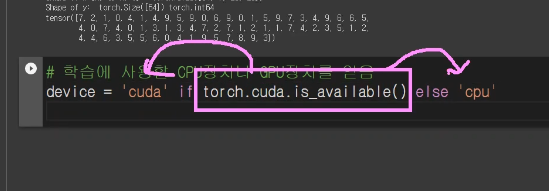

In [ ]:
# 모델을 정의

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__() # nn.Module에 있는 부모클래스를 호출. # 다른곳에 매개변수로 쓸 수 있게 super안에 넣는다
                                              # 많이쓰지않으므로 참고만 해라

        self.flatten = nn.Flatten() # 784  # 28 bytes * 28bytes  # flatten은 아무렇게 이름 붙여도 된다.
                                    # 일렬로 만들어줄때 쓰이는 객체이다(1차원으로 만듦). 연산할때 편하고, reshape하기 좋다.

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 128), # 입력이 28*28, 출력은 128   # 전체배치가 157개인데 2의 배수(128)로 정하면 자투리인 훈련데이터가 남음. 그럼 그 자투리데이터를 다시 학습시킴.
                                   # 128씩 각각의 에폭에 하다가 나머지 자투리로 계산하게되면 (갯수가 같은거로 하다가 틀린거로 하다보면 ) 다른 결과를 얻을 수 있다.
                                   # 그래서 실제 배치사이즈를 정할때 딱 맞게 배치사이즈를 정하는 것보다 따로 자투리 남겨서 하는것도 하나의 방법이다.
            nn.ReLU(), # 시그모이드랑 비슷하다고 일단 생각
            nn.Dropout(0.2), # 과대적합을 방지하기 위해 20%의 데이터를 적용시키지않고 80% 데이터를 적용시키는 함수
            nn.Linear(128, 10) # 입력 128, 출력 10
        )

    def forward(self, x): # 해당 데이터가 들어가면 자동으로 호출돼서 계산
        x = self.flatten(x) # 특정 행렬이 들어오면 일렬로 펼쳐져서 x에 저장
        logits = self.linear_relu_stack(x) # x값이 들어오면 nn.Sequential()안에 있는 것이 실행되고 연산이 돼서 logits에 저장
        return logits

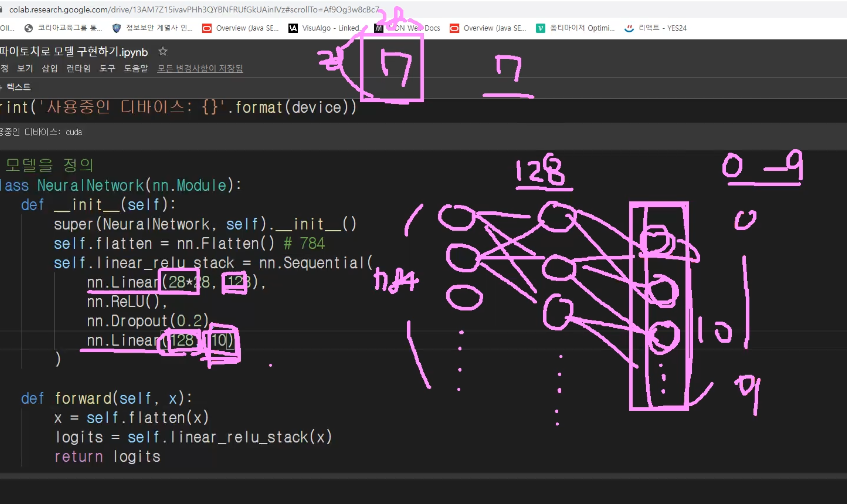

In [ ]:
# Linear(in_features=784(28*28), out_features=128(157-128=?), bias=True)
# bias=True: 해당 in_features, out_features에 의해 layer는 bias추가하여 자동으로 학습함



model = NeuralNetwork().to(device) # GPU쪽으로 객체를 보내겠다. 그래서 model이 GPU에서 만들어진다
print(model)


# (flatten): Flatten(start_dim=1, end_dim=-1) : 평탄화 작업을 해줌, 데이터를 1차원으로 만듦
# input : in_features=784
# 128개씩 쪼개서 ReLU()함수쪽으로 보냄
# 그래서 그 ReLU()함수에서 받아서 Dropout(p=0.2) 20%를 버리고
# Linear해서 128개를 받아서 10개를 내줌

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss() #loss_fn : 실제값하고 예측값하고 오차값을 구하는 함수
    # 앞에 binary가 빠진이유는 binary는 이진분류할때 쓰이고 얘는 그 이상의 데이터를 분류할때 쓰임

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Adam은 옵티마이저 종류 중 하나
                                                    # model.parameters()은 W값과 b값을 불러옴

In [ ]:
# Training을 위한 함수

def train(dataloader, model, loss_fn, optimzer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader): # batch에는 인덱스 값이 들어감,
                                     #(X, y)는 실제값이 들어감. X는 이미지값, y는 라벨값(결과값)이 들어감
        X, y = X.to(device), y.to(device) # GPU에 저장했으므로 해당 GPU로부터 X값과 y값을 받아옴

        # 예측 오류 계산
        pred = model(X)
        loss = loss_fn(pred, y) # 예측된 것 집어넣고, 실제 라벨을 집어넣고

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'loss: {loss:>7f} [{current:>5d}/{size:>5d}]')

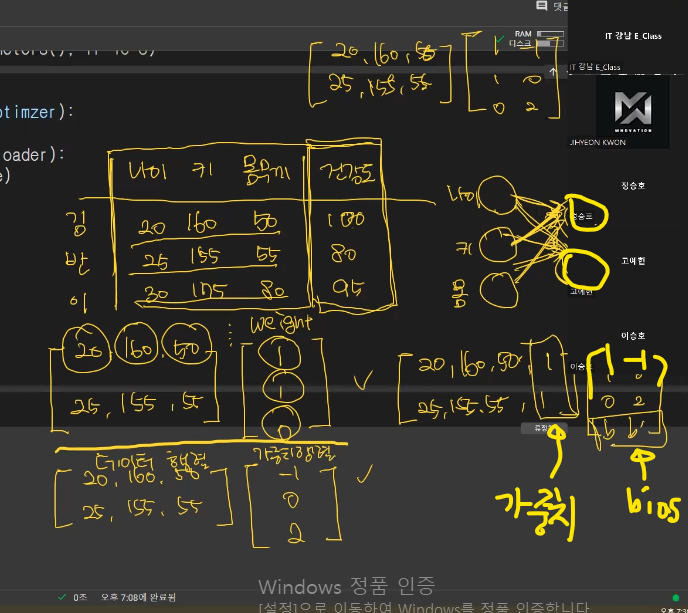

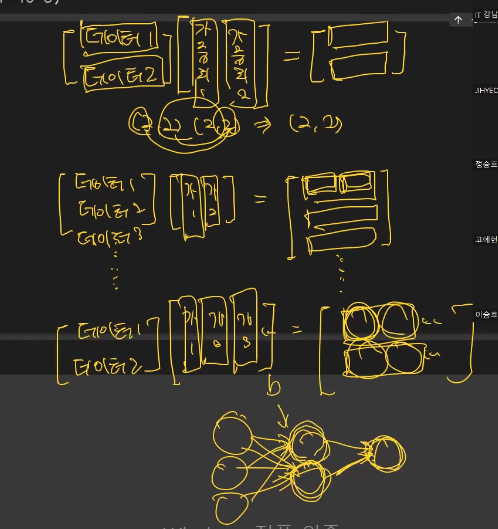

In [ ]:
epochs = 10
for t in range(epochs):
    print(f'Epoch {t+1}\--------------------')
    train(train_dataloader, model, loss_fn, optimizer)
print('끝!')

Epoch 1\--------------------
loss: 2.310756 [    0/60000]
loss: 0.429503 [ 6400/60000]
loss: 0.351745 [12800/60000]
loss: 0.391940 [19200/60000]
loss: 0.239558 [25600/60000]
loss: 0.347479 [32000/60000]
loss: 0.150937 [38400/60000]
loss: 0.399995 [44800/60000]
loss: 0.246217 [51200/60000]
loss: 0.311269 [57600/60000]
Epoch 2\--------------------
loss: 0.163739 [    0/60000]
loss: 0.212063 [ 6400/60000]
loss: 0.160993 [12800/60000]
loss: 0.237339 [19200/60000]
loss: 0.175500 [25600/60000]
loss: 0.222954 [32000/60000]
loss: 0.077031 [38400/60000]
loss: 0.264192 [44800/60000]
loss: 0.150268 [51200/60000]
loss: 0.245962 [57600/60000]
Epoch 3\--------------------
loss: 0.066753 [    0/60000]
loss: 0.147099 [ 6400/60000]
loss: 0.098323 [12800/60000]
loss: 0.187002 [19200/60000]
loss: 0.111917 [25600/60000]
loss: 0.204147 [32000/60000]
loss: 0.069865 [38400/60000]
loss: 0.227414 [44800/60000]
loss: 0.191631 [51200/60000]
loss: 0.253466 [57600/60000]
Epoch 4\--------------------
loss: 0.078213

In [ ]:
# Test을 위한 함수

def test(dataloader, model, loss_fn): # test는 옵티마이저(학습)가 필요없으니 뺀다
    size = len(dataloader.dataset)
    num_batches = len(dataloader) # 데이터로더만큼 배치를 정해준다.
    model.eval()  # dropout(오버피팅방지)시키는 레이어에서 그때 얘를 작동
    test_loss, current = 0, 0 # 둘 다 0으로 초기화시킴


    # autograd를 사용하지 않음으로 메모리 사용량을 줄이고 연산 속도를 높임
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item() # test_loss에 계속 누적시킴
            current += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss /= num_batches
        current /= size
        print(f'Test Error: \n Accuracy: {(100*current):>0.1f}%, Avg loss: {test_loss:>8f} \n')

In [ ]:
epochs = 10
for t in range(epochs):
    print(f'Epoch {t+1}\--------------------')
    train(train_dataloader, model, loss_fn, optimizer)
    test(train_dataloader, model, loss_fn)
print('끝!')

Epoch 1\--------------------
loss: 0.047770 [    0/60000]
loss: 0.017115 [ 6400/60000]
loss: 0.022196 [12800/60000]
loss: 0.029416 [19200/60000]
loss: 0.022272 [25600/60000]
loss: 0.039412 [32000/60000]
loss: 0.050736 [38400/60000]
loss: 0.060696 [44800/60000]
loss: 0.025224 [51200/60000]
loss: 0.021976 [57600/60000]
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.025512 

Epoch 2\--------------------
loss: 0.030013 [    0/60000]
loss: 0.019251 [ 6400/60000]
loss: 0.022000 [12800/60000]
loss: 0.011121 [19200/60000]
loss: 0.011000 [25600/60000]
loss: 0.026006 [32000/60000]
loss: 0.008982 [38400/60000]
loss: 0.016793 [44800/60000]
loss: 0.050640 [51200/60000]
loss: 0.008813 [57600/60000]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.017115 

Epoch 3\--------------------
loss: 0.012941 [    0/60000]
loss: 0.010482 [ 6400/60000]
loss: 0.022961 [12800/60000]
loss: 0.017453 [19200/60000]
loss: 0.011563 [25600/60000]
loss: 0.016910 [32000/60000]
loss: 0.007462 [38400/60000]
loss: 0.012128 [44800/6000

In [ ]:
import os
from PIL import Image
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('file:{name}, length:{length}bytes'.format(name=fn, length=len(uploaded[fn])))

In [ ]:
cur_dir = os.getcwd() # 파일이 올라가있는걸 불러오기위해 현재 경로를 얻어옴
img_path = os.path.join(cur_dir, '8.png') # 합칠건데 cur_dir랑 8.png를

cur_img = Image.open(img_path) # img_path를 읽어들여서 cur_img에 저장
cur_img = cur_img.resize((28, 28)) # 28 * 28 로 resize시킴
image = np.asarray(cur_img) # 넘파이의 ndarray로 이미지바꿔줌

try:
    image = np.mean(image, axis=2) # 평균을 낸다. axis=2는 컬러값(0은 행, 1은 열, 2는 컬러값)
except:  # try에서 문제생기면 지나가게끔 한다. 크게 의미는 없다
    pass

image = np.abs(255-image)  # 배경이 255, 검은색은 0 이므로 255-image에서 절대값한다 -> 그럼 반전효과가 나타남
              # 손글씨 데이터 전부가 배경이 검은색에 숫자는 흰색이므로 비교하기위해 일부로 절대값한 것
image = image.astype(np.float32) / 255. # 0 ~ 1사이의 소수
plt.imshow(image, cmap='gray')
plt.show()

FileNotFoundError: ignored

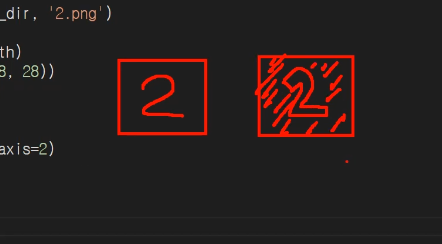

In [ ]:
image = torch.as_tensor(image).to(device).reshape(1, 1, 28, 28)
# ndarray를 텐서로 바꿔주고, device에서 끄집어냄
# 모든 레이어가 evaluation mode로 변경: 학습할 때만 필요한 Dropout, Batchnorm등의 기능을 비활성화

model.eval()
predict = model(image)
print('model이 예측한 값: {}'.format(predict.argmax(1).item()))

NameError: ignored

# 1. 순전파(forward propagation)

* 순전파는 입력받은 데이터를 각 가중치와 곱하여 출력을 뽑아내는 과정
* 입력층부터 차례로 계산해가며 출력층까지 나아감

# 2. 역전파(backpropagation)

* 순전파의 반대방향으로 전파시키는 방법
* 출력층으로부터 입력층까지 역으로 나감
* 역전파의 순서
    1. 주어진 입력값에 상관없이 임의 초기 가중치를 준 뒤 은닉층을 거쳐 결과를 계산(순전파)
    2. 계산 결과와 실제 예측하고자 하는 값 사이의 오차를 구함(loss function)
    3. 계산식의 반대로 돌아가며(미분) 가중치를 업데이트(역전파)
    4. 1~3의 과정을 오차가 더이상 줄지 않을 때까지 반복(에폭)

### 2-1. 경사하강법
* 딥러닝 알고리즘 학습시 사용되는 최적화 방법(Optimizer)
* 경사하강법의 종류
    1. 배치 경사 하강법(Batch Gradient Descent)
        - 가장 기본적인 경사 하강법으로 Vanilla Gradient Descent라고 부름
        - 데이터셋 전체를 고려하여 손실함수를 계산
        - 한번의 Epoch에 모든 파라미터 업데이트를 단 한번만 수행
        - 모델 학습시 많은 시간과 메모리가 필요하다는 단점
    2. 확률적 경사 하강법(Stochastic Gradient Descent)
        - 배치 경사 하강법의 단점을 개선하기 위해 제안
        - Batch size를 1로 설정하여 파라미터를 업데이트하기 때문에 훨씬 빠르고 적은 메모리로 학습이 진행
        - 파라미터 값의 업데이트 폭이 불안정하기 때문에 정확도가 낮은 경우가 생기기도 함
    3. 미니 배치 경사 하강법(Mini-Batch Gradient Descent)
        -  일반적으로 배치사이즈를 32, 64, 128과 같이 2의 n제곱에 해당하는 값으로 설정하고 적용하는 방법
        - 모델 학습 속도가 빠르고, 확률적 경사 하강법보다 안정적인 장점
    4. Momentum
        - 운동량을 의미하며 매개변수의 이동에 속도를 부여하는 것을 의미
        - 매개변수를 갱신할 때마다 기존속도에 매개변수의 기울기값을 추가하고 이 속도값을 다시 매개변수에 추가하여 매개변수를 이동
        - SGD 가 가지고 있는 문제인 local Minima를 해결할 수 있는 방법
    5. Nesterov Momentum
        - 현재의 속도 벡터와 현재 속도로 한 걸음 미리 가 본 위치의 그레디언트 벡터를 더해 다음 위치를 정함
        - 속도 Vt+1는 현재 속도에 마찰 계수(p)를 곱한 뒤 한걸음 미리 가 본 위치의 그레디언트를 빼서 계산
        - 오버슈팅을 막기 위해 현재 속도로 한 걸음 미리 가 보고 오버 슈팅이 된 만큼 다시 내리막길로 내려가는 방식
    6. AdaGrad
        - Adaptive Gradient의 줄임말
        - 손실 함수 곡면의 변화에 따라 적응적으로 학습률을 정하는 알고리즘
        - 손실 함수 경사가 가파를 때 큰 폭으로 이동하면 최적화 경로를 벗어나서 최소 지점을 지나갈 수 있음
        - 많이 변화한 변수는 최적해에 근접했을거란 가정하에 작은 크기로 이동하면서 세밀하게 값을 조정하고 반대로 적게 변화한 변수들은 학습률을 크게하여 빠르게 오차 값을 줄이고자 하는 방법
    7. RMSProp
        - AdaGrad에서 학습이 안되는 문제를 해결하기 위해 hyper parameter인 β가 추가
        - 변화량이 더 클수록 학습률이 작아져서 조기 종료되는 문제를 해결하기 위해 학습률 크기를 비율로 조절할 수 있도록 제안된 방법
    8. Adam
        - Adam은 Mementum과 RMSProp이 합쳐진 형태
        - 진행하던 속도에 관성도 주고, 최근 경로의 곡면의 변화량에 따른 적응적 학습률을 갖는 알고리즘
        - 매우 넓은 범위의 아키텍처를 가진 서로 다른 신경망에서 잘 작동한다는 것이 증명됨

### 2-2. 활성화 함수
* Activation function이라고 부르며 신경망의 출력을 결정하는 식
* 신경망에서는 뉴런(노드)에 연산 값을 계속 전달해주는 방식으로 가중치를 훈련하고 예측 -> 각각의 함수는 네트워크의 각 뉴런에 연결되어 있으며 각 뉴런의 입력이 모델의 예측과 관련이 있는지 여부에 따라 활성화 -> 활성화를 통해 신경망은 입력값에서 필요한 정보를 학습
* 훈련 과정에서 계산량이 많고 역전파에서 사용해야 하므로 연산의 대한 효율성이 매우 중요

* 활성화 함수의 종류
    1. Binary step function
        - 퍼셉트론 알고리즘에서 활성화 함수로 사용
        - 다중 분류 문제에서 다중 출력을 할 수 없다는 단점
    2. Linear activation function
        - 선형 활성화 함수
        - 입력값에 특정 상수값을 곱한 값을 출력으로 가짐
        - 다중 출력이 가능
        - 역전파에 사용이 불가능
        - 선형함수를 여러번 사용하는 것은 마지막에 선형함수를 한번 쓰는 것과 같음
    3. Non-linear activation function
        - 최근 신경망 모델에서 대부분 사용
        - 입력과 출력간의 복잡한 관계를 만들어 입력에서 필요한 정보를 얻음
        - 입력과 관련있는 미분값을 얻으며 역전파를 가능
* Non-linear activation function의 종류
    1. Sigmoid
        - 로지스틱으로도 불리는 s자 형태의 함수
        - 입력값이 커질수록 1로 수렴하고, 입력값이 작을수록 0에 수렴
        - 역전파시 Vanishing Gradient 문제가 발생
        - 출력의 중심이 0이 아님. 비용/효율면에서 좋지 못함
        - 퍼셉트론, 초기 신경망에서 많이 사용지만 여러 단점들 때문에 현재는 많이 사용하지 않음
    2. ReLU
        - Rectified Linear Unit 함수의 준말로 개선 선형 함수라고 부름
        - CNN에서 좋은 성능을 보였고, 현재 딥러닝에서 가장 많이 사용하는 활성화 함수
        - 비선형. 도함수를 가지며, 역전파를 허용
        - 입력값이 0 또는 음수일 때 gradient값은 0이되며 이 경우 학습을 하지 못함.
    3. softmax
        - 다중 분류 문제를 해결하기 위해 많이 사용되는 함수
        - 입력받은 값을 0에서 1사이의 값으로 모두 정규화하며 출력값이 여러개임
        - 출력값의 총합은 항상 1이 되는 특징을 가짐
        - 지수함수를 사용하여 오버플로 발생이 가능

# 3. FashionMNIST DataSet

In [ ]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



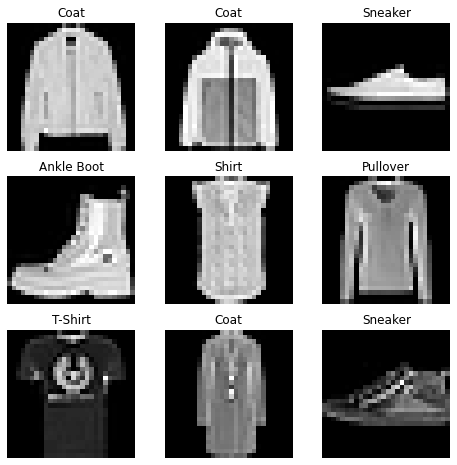

In [ ]:
labels_map = { # 딕셔너리구조 key : value
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3 # 3*3=9개의 사진을 뿌려보기
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    # 전체 데이터에서 랜덤하게 뽑아서 사이즈를 1로 하고, 거기에 있는 해당하는 아이템을 가져와서 sample_idx에 넣어줌
    img, label = training_data[sample_idx] # img와 label값을 뽑아봄
    figure.add_subplot(rows, cols, i) # 가로 세로 i값
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray') #squeeze()는 채널을 삭제
plt.show()

In [ ]:
# DataLoader 만들기

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
labels batch shape: torch.Size([64])


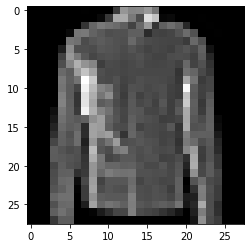

Label: 6


In [ ]:
train_features, train_labels = next(iter(train_dataloader)) # 데이터들과 정답들
     # iter() : 탐색하는 함수,  탐색한데이터를 next가 해당리스트에 담아줌
     # 64개 배치, 1개씩, 28by 28

print(f'Feature batch shape: {train_features.size()}')
print(f'labels batch shape: {train_labels.size()}')

img = train_features[0].squeeze() # 차원을 하나 낮춰서 흑백이 됨
label = train_labels[0]
plt.imshow(img, cmap='gray')
plt.show()
print(f'Label: {label}')

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('사용하는 디바이스: {}'.format(device))

사용하는 디바이스: cpu


In [ ]:
# Model class 만들기
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()  # 일차원으로 데이터를 평평하게 만들어줌
        self.linear_relu_stack = nn.Sequential( # Sequential을 만들어서 레이어를 쌓음
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
# 가상의 데이터를 만들어서 예측

X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f'예측된 클래스: {y_pred}')

예측된 클래스: tensor([1])


In [ ]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Adam이 제일 성능이 좋음

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader): # 데이터로더에 갯수만큼 반복하는데 거기에서 인덱스값은 batch, 데이터는 (X,y), X에는 이미지값, y에는 라벨값
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y) #예측과 실제값을 비교해서 로스값을 얻어냄
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:  # 배치가 100번마다
            loss, current = loss.item(), batch * len(X)
            print(f'loss:{loss:>7f} [{current:>5d}/{size:>5d}]')

In [ ]:
def test_loop(dataloader, model, loss_fn):  # 학습을 시키는게 아니니까 옵티마이저 제외
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, current = 0, 0

    model.eval() # 성능을 올려줌

    with torch.no_grad(): # 메모리 절약
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()  # loss값을 누적시킴
            current += (pred.argmax(1) == y).type(torch.float).sum().item()
            # 확률이 가장 높은 애를 데리고나와서 y값과 일치하는지 확인하고, 토치플롯으로 바꾸고, 합치고, item을 뽑음

        test_loss /= num_batches
        current /= size
        print(f'Test Error: \n Accuracy:{(100*current):>0.1f}%, Avg loss: {test_loss:8f} \n')

In [ ]:
# 학습

epochs = 10

for t in range(epochs):
    print(f'Epoch {t+1}\---------------------')
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print('끝!')

Epoch 1\---------------------
loss:2.298925 [    0/60000]
loss:0.592867 [ 6400/60000]
loss:0.744983 [12800/60000]
loss:0.702542 [19200/60000]
loss:0.507282 [25600/60000]
loss:0.398601 [32000/60000]
loss:0.476232 [38400/60000]
loss:0.474943 [44800/60000]
loss:0.382625 [51200/60000]
loss:0.730910 [57600/60000]
Test Error: 
 Accuracy:83.6%, Avg loss: 0.458664 

Epoch 2\---------------------
loss:0.483750 [    0/60000]
loss:0.433896 [ 6400/60000]
loss:0.441194 [12800/60000]
loss:0.548424 [19200/60000]
loss:0.255845 [25600/60000]
loss:0.486984 [32000/60000]
loss:0.379012 [38400/60000]
loss:0.293440 [44800/60000]
loss:0.397290 [51200/60000]
loss:0.409663 [57600/60000]
Test Error: 
 Accuracy:85.6%, Avg loss: 0.406364 

Epoch 3\---------------------
loss:0.277932 [    0/60000]
loss:0.378450 [ 6400/60000]
loss:0.348376 [12800/60000]
loss:0.442466 [19200/60000]
loss:0.368744 [25600/60000]
loss:0.310490 [32000/60000]
loss:0.336168 [38400/60000]
loss:0.488069 [44800/60000]
loss:0.290053 [51200/600

In [ ]:
# 학습된 model parameter 저장

torch.save(model.state_dict(), 'model_weights.pth')


# 파일에 저장 .
# 저장하는 이유는 학습된 모델을 파일(model_weights.pth)로 만들어서 이 파일을 나중에 앱이나 웹사이트를 만들때 거기에 이 파일을 넣어주고
# 사용자가 입력하는 이미지나 웹에서 입력된 이미지를 파일에 넣어서 연산하게끔 만듦. 그래서 이 파일(model_weights.pth)은 준비된,학습된 파일임.

In [ ]:
# 새로운 model을 생성
model2 = NeuralNetwork().to(device)
print(model2)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
# 테스트

model2.eval()
test_loop(test_dataloader, model2, loss_fn)

Test Error: 
 Accuracy:11.2%, Avg loss: 2.319398 



In [ ]:
# 저장된 parameter 불러오기

model2.load_state_dict(torch.load('model_weights.pth'))
model2.eval()
test_loop(test_dataloader, model2, loss_fn)

Test Error: 
 Accuracy:87.8%, Avg loss: 0.337137 



In [ ]:
# model 전체를 저장하고 불러오기

torch.save(model, 'model.pth')

In [ ]:
# 불러오기

model3 = torch.load('model.pth')

In [ ]:
# 테스트

model3.eval()
test_loop(test_dataloader, model3, loss_fn)

Test Error: 
 Accuracy:87.8%, Avg loss: 0.337887 

